**Load in Phi model**

In [9]:
%pylab inline 
phi_dat = np.load('/mnt/store1/oliverphilcox/PowerSpectra/Phi_Correction_Multipoles.npz')
phi_coeff = phi_dat.f.multipole_coeff
def phi_model(ell,r):
    l_i = ell//2
    co = phi_coeff[l_i]
    return co[0]+co[1]*r+co[2]*r**2.+co[3]*r**3.+co[4]*r**4.

Populating the interactive namespace from numpy and matplotlib


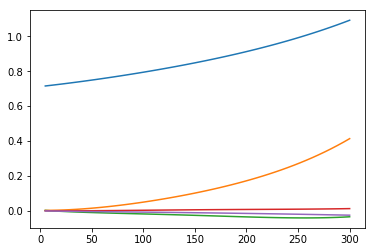

In [11]:
r_all = np.linspace(5,300)
for ell in [0,2,4,6,8]:
    plt.plot(r_all,phi_model(ell,r_all))

**Compute Window Function**

In [117]:
def windower(r,R_cut,R_max):
    b = R_cut/R_max
    a = (R_max-R_cut)/(2.*R_max)
    x = r/R_max
    if type(r)==float or type(r)==np.float64:
        if x<b:
            return 1.
        elif x<b+a:
            return 1.-1.25*((x-b)/a)**4.+0.75*((x-b)/a)**5.
        elif x<1:
            return 1.25*((x-b-2*a)/a)**4.+0.75*((x-b-2*a)/a)**5.
        else:
            return 0.
    else:
        output = np.zeros_like(r)
        x = r/R_max
        filt1 = np.where(x<b)
        filt2 = np.where((x>b)&(x<b+a))
        filt3 = np.where((x>b+a)&(x<1))
        output[filt1] = 1.
        output[filt2] = 1.-1.25*((x[filt2]-b)/a)**4.+0.75*((x[filt2]-b)/a)**5.
        output[filt3] = 1.25*((x[filt3]-b-2*a)/a)**4.+0.75*((x[filt3]-b-2*a)/a)**5.
        return output

**Load Correlation Function Model**

In [118]:
xi_file = '/mnt/store1/oliverphilcox/DR12_QPM/RascalXi.xi'
xi_r = np.genfromtxt(xi_file,max_rows=1)
xi_mu = np.genfromtxt(xi_file,max_rows=1,skip_header=1)
xi_dat = np.loadtxt(xi_file,skiprows=2)
radial_xi_dat = xi_dat.mean(axis=1)
extra_r = np.arange(max(xi_r)+xi_r[1]-xi_r[0],1000,xi_r[1]-xi_r[0])
xi_r_all=np.concatenate([[0],xi_r,extra_r])
xi_model_all = np.concatenate([[0],radial_xi_dat,radial_xi_dat[-1]/extra_r**4.*xi_r[-1]**4.])

In [15]:
xi_ell = np.zeros([len(xi_dat),3])
from scipy.special import legendre
for l_i,ell in enumerate([0,2,4]):
    xi_ell[:,l_i] = (2.*ell+1.)*(xi_mu[1]-xi_mu[0])*np.sum(xi_dat*legendre(ell)(xi_mu),axis=1)

In [17]:
class xi_spline():
    def __init__(self,ell):
        l_i=ell//2
        extra_r = np.arange(max(xi_r)+xi_r[1]-xi_r[0],1000,xi_r[1]-xi_r[0])
        xi_r_all=np.concatenate([[0],xi_r,extra_r])
        self.xi_ell_all = np.concatenate([[0],xi_ell[:,l_i],xi_ell[-1,l_i]/extra_r**4.*xi_r[-1]**4.])
        self.xi_fit = UnivariateSpline(xi_r_all,xi_r_all**2.*self.xi_ell_all,s=10)
    def r2xi_spline(self,r):
        if type(r)==float:
            if r>max(xi_r_all):
                return 0.
            else:
                return self.xi_fit(r)
        else:
            xi_out = np.zeros_like(r)
            filt = np.where(r<max(xi_r_all))
            xi_out[filt]=self.xi_fit(r[filt])
            return xi_out

In [19]:
spl0=xi_spline(0)
spl2=xi_spline(2)
spl4=xi_spline(4)

def all_spl(ell):
    if ell==0:
        return spl0
    elif ell==2:
        return spl2
    else:
        return spl4

In [121]:
from sympy.physics.wigner import wigner_3j
from scipy.integrate import quad
from scipy.special import spherical_jn
def aniso_pow(k_all,ell,R0):
    out=np.zeros_like(k_all)
    for l1 in [0,2,4]:
        for l2 in [0,2,4]:
            wig = wigner_3j(ell,l1,l2,0,0,0)
            if wig!=0:
                k_int = lambda kk: quad(lambda r: spherical_jn(ell,kk*r)*all_spl(l1).r2xi_spline(r)*windower(r,R0/2,R0)*phi_model(l2,r),0,R0,epsrel=1e-4)
                tmp_int = np.asarray([k_int(kk)[0] for kk in k_all])
                out+=tmp_int*float(wig.n())
    return out*4.*np.pi*(-1.)**(ell/2.)

In [126]:
def true_pow(k_all,ell):
    k_int = lambda kk: quad(lambda r: spherical_jn(ell,kk*r)*all_spl(ell).r2xi_spline(r),0,np.inf)
    tmp_int = np.asarray([k_int(kk)[0] for kk in k_all])
    return tmp_int*4.*np.pi*(-1.)**(ell/2.)

In [127]:
k_all = np.linspace(0.05,1.,20)
pows=aniso_pow(k_all,0,200)
true=true_pow(k_all,0)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


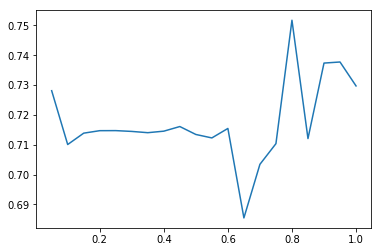

In [128]:
plt.plot(k_all,pows/true)

In [104]:
np.zeros_like(np.asarray(k_all))+x

array([980.520215687567, 62.8247936355778, 11.5369241507840], dtype=object)

In [ ]:
def true_power_aniso(k,ell):
    li=ell//2
    this_spl = all_spl(ell)
    tmp_int=quad(lambda r: (-1.)**(ell/2.)*this_spl.r2xi_spline(r)*spherical_jn(ell,k*r)*4.*np.pi,0,np.inf,epsrel=1e-6,limit=200)
    return tmp_int[0]